In [35]:
import numpy as np
import pandas as pd
from datetime import datetime
from collections import Counter
from collections import OrderedDict
import matplotlib.pyplot as plt
from plotnine import *

plt.style.use("ggplot")
%matplotlib inline

In [164]:
## Dataset loading
df = pd.read_csv("../data/Anonymized_Buckeye_issue_log_dataset.csv", encoding="ISO-8859-1", index_col=0)
ti = df["SentOn"].values[0].replace("+00:00", "")
tf = df["SentOn"].values[-1].replace("+00:00", "")
dt = datetime.strptime(tf, '%Y-%m-%d %H:%M:%S') - datetime.strptime(ti, '%Y-%m-%d %H:%M:%S')
df = df.dropna()

# Timelines definition
senton_time = [datetime.strptime(d.replace("+00:00", ""), 
                          '%Y-%m-%d %H:%M:%S') for d in df["SentOn"].values]
senton_timeline = np.cumsum(np.diff(senton_time))
senton_timeline = [0] + [el.seconds for el in senton_timeline]

received_time = [datetime.strptime(d.replace("+00:00", ""), 
                          '%Y-%m-%d %H:%M:%S') for d in df["ReceivedTime"].values]
received_timeline = np.cumsum(np.diff(received_time))
received_timeline = [0] + [el.seconds for el in received_timeline]
delay = [(r-s) for r, s in zip(received_timeline, senton_timeline)]
df_time = pd.DataFrame()
df_time['Relative sent time [s]'] = senton_timeline
df_time['received'] = received_timeline
df_time['Travel time [s]'] = delay
df_time['Region'] = df['Region']
df_time = df_time.dropna()
df_time = df_time.iloc[1:]

# Angriness binned
labels = ('Not angry', 'Moderately angry', 'Angry')
bins = [0, 0.3, 0.8, 1]
df["AngrinessBinned"] = pd.cut(df["Angriness"], bins, labels=labels)

# Words
with open('../data/cloud_text.txt') as fobj:
    words = Counter(fobj.read().replace(",", '').replace(":", '').lower().split(' '))

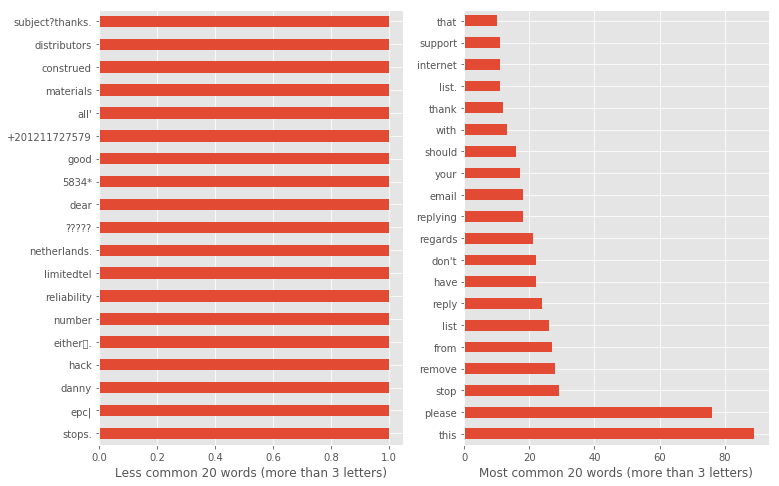

In [130]:
most_common = [w for w in words.most_common()[1:47] if len(w[0]) > 3]
less_common = [w for w in words.most_common()[-20:] if len(w[0]) > 3]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8))
df_mc = pd.DataFrame(OrderedDict(most_common), index=('Word Count',)).T
df_lc = pd.DataFrame(OrderedDict(less_common), index=('Word Count',)).T
df_mc.plot(kind='barh', figsize=(12, 8), ax=ax2, legend=False)
ax2.set_xlabel('Most common 20 words (more than 3 letters)');
df_lc.plot(kind='barh', figsize=(12, 8), ax=ax1, legend=False)
ax1.set_xlabel('Less common 20 words (more than 3 letters)');

# Q1

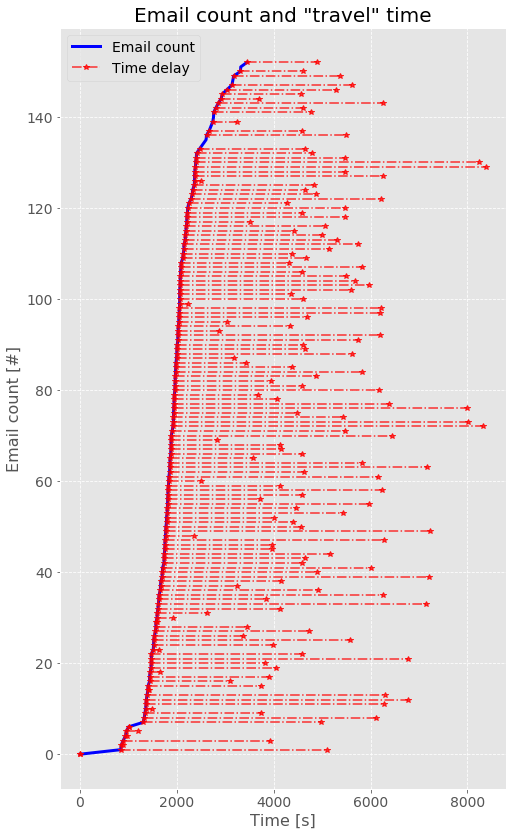

In [124]:
fig = plt.figure(figsize=(8, 14))
plt.plot(senton_timeline, df.index, 'b', lw=3)
for idx in df.index:
    try:
        plt.plot((senton_timeline[idx], senton_timeline[idx]+delay[idx]),
                 (df.index[idx], df.index[idx]), 
                 'r-.*', alpha=0.8, ms=6)
    except IndexError:
        pass
plt.grid(True, linestyle='--')
plt.xlabel('Time [s]', fontsize=16)
plt.ylabel('Email count [#]', fontsize=16)
plt.tick_params(axis='both', labelsize=14)
plt.legend(('Email count', 'Time delay'), loc=2, fontsize=14)
plt.title('Email count and "travel" time', size=20)
plt.savefig('../images/eda_q1.png')

/home/peppe/.virtualenvs/py35/lib/python3.5/site-packages/plotnine/ggplot.py:688: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/home/peppe/.virtualenvs/py35/lib/python3.5/site-packages/plotnine/ggplot.py:689: UserWarning: Filename: ../images/eda_q1_2.png
  warn('Filename: {}'.format(filename))


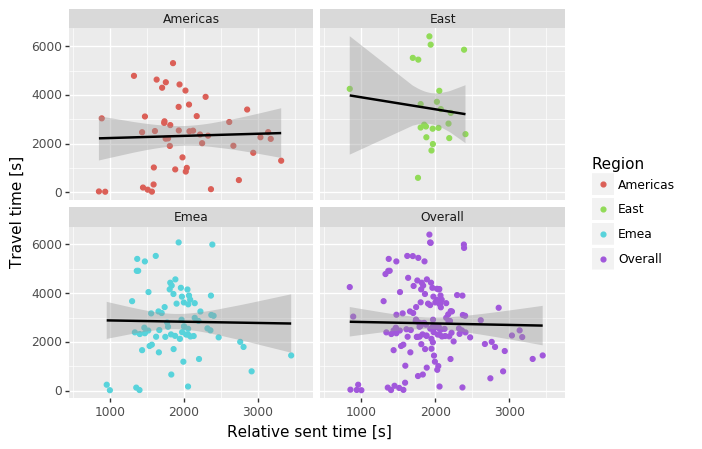

In [209]:
df2 = pd.DataFrame()
df2['Relative sent time [s]'] = df_time['Relative sent time [s]']
df2['received'] = df_time['received'] 
df2['Travel time [s]'] = df_time['Travel time [s]']
df2['Region'] = 146*['Overall']
df3 = pd.concat([df_time, df2])

p1 = ggplot(df3, aes(x='Relative sent time [s]', y='Travel time [s]')) \
    + geom_point(aes(color='Region')) \
    + facet_wrap('~Region') \
    + stat_smooth(method='glm', color='black', se=True) \
    + coord_cartesian(xlim=(600, 3600))
ggplot.draw(p1)
ggplot.save(p1, filename='eda_q1_2.png', path='../images')

# Q2 - 

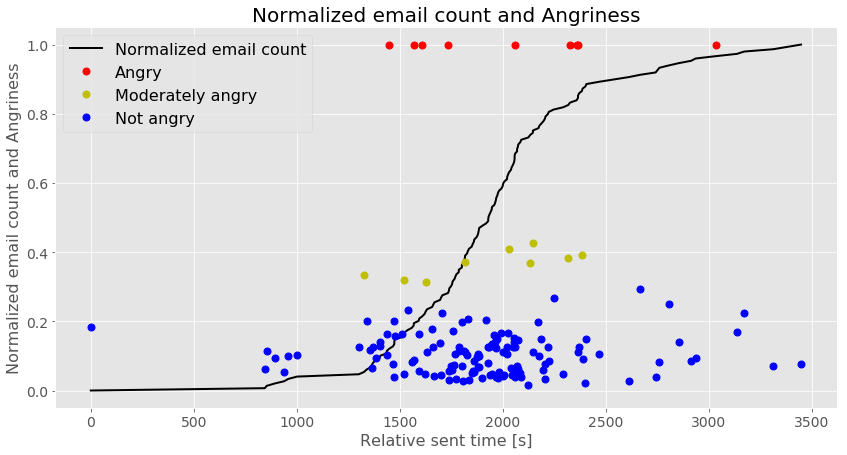

In [7]:
df2 = df.join(df_time).dropna()

fig = plt.figure(figsize=(14, 7))
p0, = plt.plot(df2.senton, df2.index/df2.index[-1], 'k', lw=2)
for idx in df2.index:
    if df2['AngrinessBinned'][idx] == "Angry":
        p1, = plt.plot(df2.senton[idx], (1,), "ro", ms=7)
    if df2['AngrinessBinned'][idx] == "Moderately angry":
        p2, = plt.plot(df2.senton[idx], (df2['Angriness'][idx],), "yo", ms=7)
    if df2['AngrinessBinned'][idx] == "Not angry":
        p3, = plt.plot(df2.senton[idx], (df2['Angriness'][idx],), "bo", ms=7)
plt.tick_params(axis='both', labelsize=14)
plt.xlabel('Relative sent time [s]', fontsize=16)
plt.ylabel('Normalized email count and Angriness', fontsize=16)
plt.legend((p0, p1, p2, p3), 
           ('Normalized email count', 'Angry', 'Moderately angry', 'Not angry'), loc=2, fontsize=16)
plt.title('Normalized email count and Angriness', size=20)
plt.savefig('../images/eda_q2.png', dpi=250);

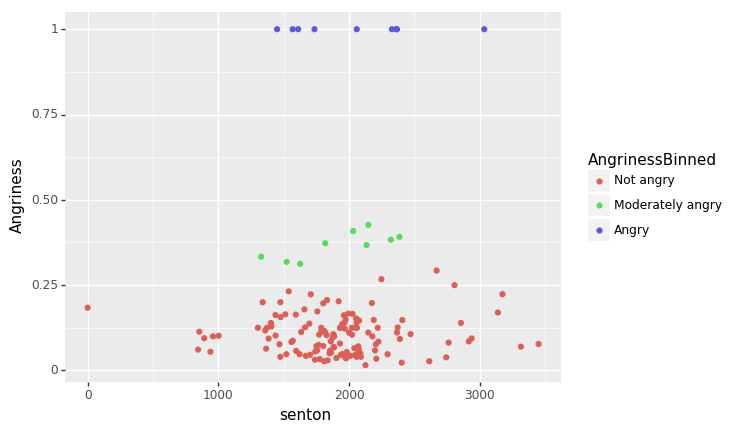

<ggplot: (-9223372036840713198)>

In [166]:
ggplot(df2, aes(x='senton', y="Angriness")) \
    + geom_point(aes(color='AngrinessBinned'))   

In [72]:
geom_line?

# Q3

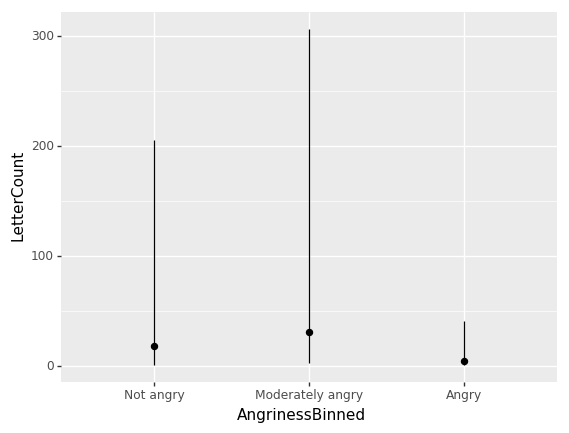

<ggplot: (12891698)>

In [8]:
ggplot(aes(x='AngrinessBinned', y='LetterCount'), data=df) \
    + stat_summary(fun_y = np.median, fun_ymin=np.min, fun_ymax=np.max)

C:\Apps\miniconda64\lib\site-packages\plotnine\ggplot.py:552: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(h, units), units))


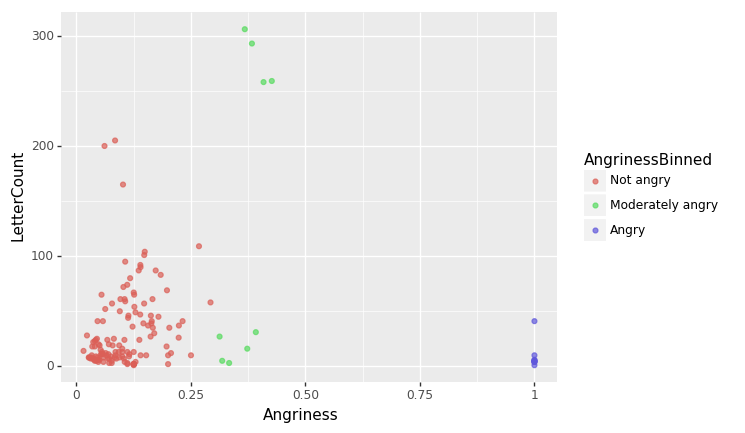

In [36]:
p = ggplot(aes(x='Angriness', y='LetterCount', color='AngrinessBinned'), data=df) \
      + geom_point(alpha=0.7) 
ggplot.draw(p)
ggplot.save(p, filename='eda_q3.png', path='../images')

# Q4

C:\Apps\miniconda64\lib\site-packages\plotnine\ggplot.py:552: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(h, units), units))


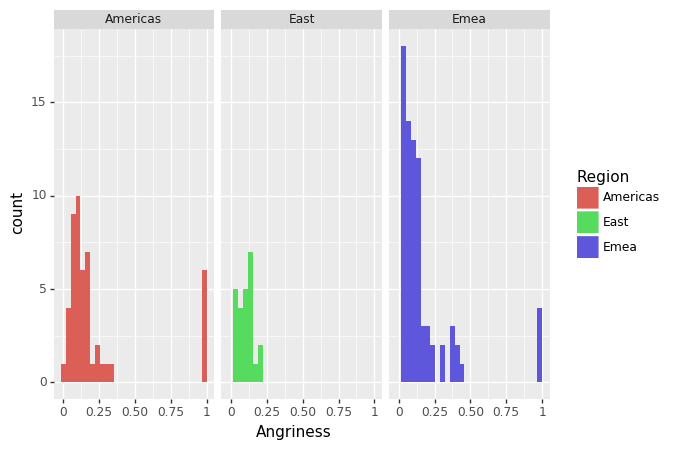

In [19]:
p = ggplot(df, aes(x="Angriness", fill='Region')) \
    + geom_histogram(bins=30) \
    + facet_grid('.~Region')
ggplot.draw(p)
ggplot.save(p, filename='eda_q4.png', path='../images')

C:\Apps\miniconda64\lib\site-packages\plotnine\ggplot.py:552: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(h, units), units))


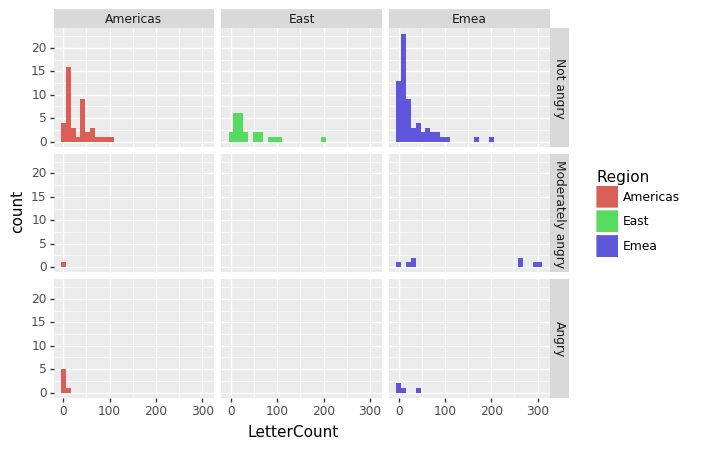

In [20]:
p = ggplot(df, aes(x="LetterCount", fill='Region')) \
    + geom_histogram(bins=30, inherit_aes=True) \
    + facet_grid("AngrinessBinned~Region")
ggplot.draw(p)
ggplot.save(p, filename='eda_q4_2.png', path='../images')

In [37]:
p = ggplot(df, aes(x="LetterCount", y="Angriness", color='Region',)) \
    + geom_point() \
    + facet_grid('.~Region') \
    + stat_smooth(method='glm')
ggplot.save(p, filename='eda_q4_3.png', path='../images')

C:\Apps\miniconda64\lib\site-packages\plotnine\ggplot.py:552: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(h, units), units))


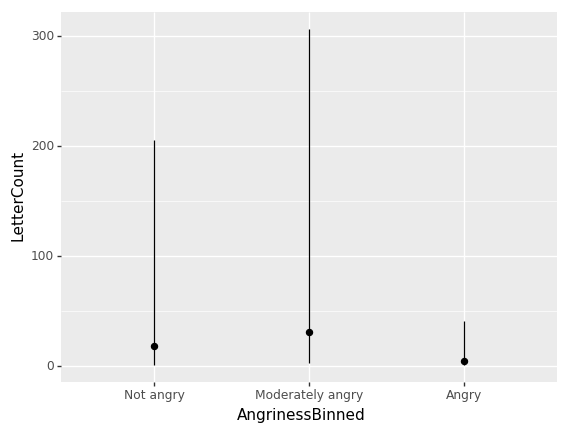

<ggplot: (-9223372036839797188)>

In [11]:
ggplot(aes(x='AngrinessBinned', y='LetterCount'), data=df) \
    + stat_summary(fun_y = np.median, fun_ymin=np.min, fun_ymax=np.max)

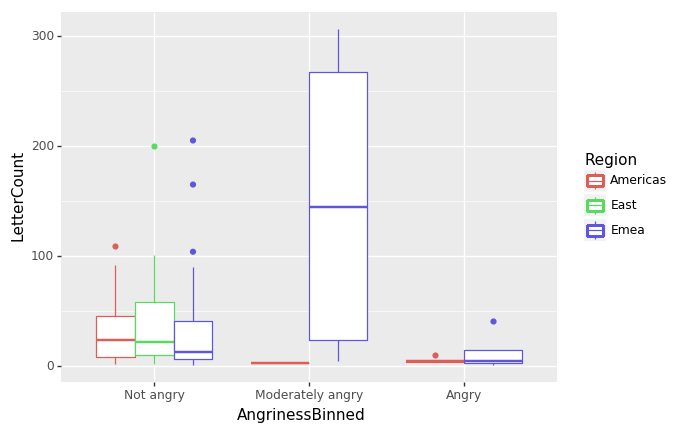

<ggplot: (13482893)>

In [12]:
ggplot(df, aes(x='AngrinessBinned', y='LetterCount', color='Region')) \
    + geom_boxplot()

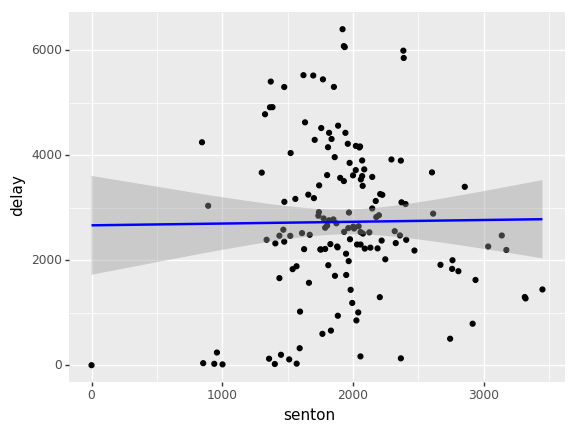

<ggplot: (15184406)>

---

In [67]:
answer1 = 'Probably yes'
answer2 = 'Apparently yes'
answer3 = 'Clearly yes'
answer4 = 'Americas and EMEA more prone to angry replies'

In [73]:
c = pd.DataFrame(index=('Answer', ))

c["Did the email storm create issues to the email servers?"] = '{}'.format(answer1)
c["Is there any relationship between the amount of emails sent/received in time and the angriness in the replies?"] = '{}'.format(answer2)
c["It there any relationship between the number of typed letters and the angriness?"] = '{}'.format(answer3)
c["Is angriness affected  by the region?"] = '{}'.format(answer4)

c.T.index.name = 'Question'
c.T

,Answer
Question,
Did the email storm create issues to the email servers?,Probably yes
Is there any relationship between the amount of emails sent/received in time and the angriness in the replies?,Apparently yes
It there any relationship between the number of typed letters and the angriness?,Clearly yes
Is angriness affected by the region?,Americas and EMEA more prone to angry replies
